In [60]:
import pandas as pd, numpy as np, scipy, matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

In [61]:
df = pd.read_csv((
    "https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/"
    "master/ESS_practice_data/ESSdata_Thinkful.csv")).dropna()

df['partner'] = df['partner'] - 1
df.head()

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,0.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,0.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,1.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,0.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,0.0


In [70]:
# Additional feature engineering
df['is_male'] = pd.get_dummies(df.gndr, drop_first=True)
df['is_male_age'] = df.is_male * df.agea
df['age_happy'] = df.agea * df.happy
df.head()

# interaction variable leads to small increase in type I errors, decrease in type II errors

,cntry,idno,year,tvtot,ppltrst,pplfair,pplhlp,happy,sclmeet,sclact,gndr,agea,partner,is_male,is_male_age,age_happy
0,CH,5.0,6,3.0,3.0,10.0,5.0,8.0,5.0,4.0,2.0,60.0,0.0,1,60.0,480.0
1,CH,25.0,6,6.0,5.0,7.0,5.0,9.0,3.0,2.0,2.0,59.0,0.0,1,59.0,531.0
2,CH,26.0,6,1.0,8.0,8.0,8.0,7.0,6.0,3.0,1.0,24.0,1.0,0,0.0,168.0
3,CH,28.0,6,4.0,6.0,6.0,7.0,10.0,6.0,2.0,2.0,64.0,0.0,1,64.0,640.0
4,CH,29.0,6,5.0,6.0,7.0,5.0,8.0,7.0,2.0,2.0,55.0,0.0,1,55.0,440.0


In [71]:
# Define outcome and predictors; set partner variable to 0/1
y = df['partner']
X = df.loc[:, ~df.columns.isin(['partner', 'cntry', 'idno'])]
X = pd.concat([X, pd.get_dummies(df['cntry'])], axis=1)

# Create training and sampling sets
offset = int(X.shape[0] * 0.9)

# 90% of data to training set
X_train, y_train = X[:offset], y[:offset]

# 10% to test set
X_test, y_test = X[offset:], y[offset:]

In [74]:
# Now a classifier, loss function can only be deviance or exponential
# Using Deviance
params = {'n_estimators':1000,
          'max_depth': 5,
          'loss': 'exponential'}

# Running additional iterations: decreases errors in training set, and type I in test, increase in type II, overfit?
# Increasing depth: decreases errors in training set, and type II in test, increase in type I

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0]/table_train.loc['All', 'All']
train_tII_errors = table_train.loc[1.0,0.0]/table_train.loc['All', 'All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All', 'All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All', 'All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0010911074740861974
Percent Type II errors: 0.013229678123295145

Test set accuracy:
Percent Type I errors: 0.1165644171779141
Percent Type II errors: 0.1754601226993865




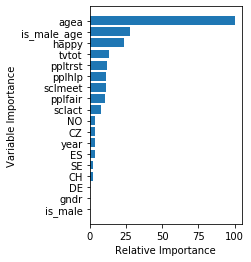

In [65]:
features_importance = clf.feature_importances_

# Set factor of importance relative to most important feature
features_importance = 100.0 * (features_importance/features_importance.max())
sorted_idx = np.argsort(features_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1,2,2)
plt.barh(pos, features_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.ylabel('Variable Importance')
plt.show()